## Unit Name: Technology Capstone Project PG
## Unit ID: 11522
## Semester 2, 2022
## University of Canberra

### 11522-22-13 American Express - Default Prediction 

### Group Members
#### 1) Riya Saji Mathew, Student ID: u3219983
#### 2) Anu Maria George, Student ID: u3228397
#### 3) Atul Katoch, Student ID: u122615
#### 4) Priyank Sharma, Student ID: u3225285

### Academic Supervisor
#### Dr. Ibrahim Radwan



## Prologue

American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success. In this project we’ll apply our machine learning skills to predict credit default. Specifically, we will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. We explore techniques to create the most powerful model, from creating features to using the data in a more organic way within a model.If successful, we'll help create a better customer experience for cardholders by making it easier to be approved for a credit card.

The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

## About the Dataset
The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

with the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

We're provided with 3 data files and one submission file. 

1) train_data.csv - training data with multiple statement dates per customer_ID

2) train_labels.csv - target label for each customer_ID

3) test_data.csv - corresponding test data; your objective is to predict the target label for each customer_ID

4) sample_submission.csv - a sample submission file in the correct format

In [9]:
#First we start by importing all the necessary libraries we need to perform our tasks on our dataset.

import pandas as pd #for data wrangling and manipualtion
import numpy as np #for data wrangling and manipualtion
import matplotlib.pyplot as plt #for plots
import plotly.express as px #for interactive plots
import seaborn as sns #for plots
import missingno as msno  #for missing value plot
import gc #interface for garbage collector
from matplotlib import gridspec #for plots

from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder) #for encoding non-numeric variables
import warnings
warnings.filterwarnings("ignore") #for removing warnings to keep output less noisy
from sklearn.impute import SimpleImputer, MissingIndicator #for imputation purposes

from sklearn.preprocessing import StandardScaler #for standardization
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA #for dimensionality reduction
# importing pipeline for chaining model building activities
from imblearn.pipeline import Pipeline #for using pipe
from imblearn.pipeline import make_pipeline as mp
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE, RandomOverSampler #for data imbalance handling
from imblearn.under_sampling import RandomUnderSampler #for data imbalance handling
from sklearn.model_selection import train_test_split #for splitting the dataset
from sklearn.feature_selection import SelectFromModel     #for feature selection    
#importing necessary classifiers for model fitting and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#for model evaluation meetrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, roc_auc_score
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_predict, cross_val_score, validation_curve, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV

In [10]:
#Defining Path for all imput files. Here we have taken a small subset of the bigger dataset. That is substantial enough to give results that are applicable on entire poplation of data.
small_train_path = "C:/Users/win x/Downloads/amex-default-prediction (2)/amex-default-prediction/small_train.csv"
small_test_path= "C:/Users/win x/Downloads/amex-default-prediction (2)/amex-default-prediction/small_test.csv"
train_labels = "C:/Users/win x/Downloads/amex-default-prediction (2)/amex-default-prediction/train_labels.csv"

#Reading files through read_csv function and storing in respective dataframes.
small_train_df = pd.read_csv(small_train_path)
small_test_df = pd.read_csv(small_test_path)
data_labels = pd.read_csv(train_labels)

In [11]:
#We now print number of rows and columns of datasets indivdually and try to see how the values look like by using head and tail function.
#We pass 3 as parameter in function to view 3 rows. Therefore, we observe the nitial 3 and ending 3 values in the dataset.

print('Number of rows in train dataset:', small_train_df.shape[0])
print('Number of columns in train dataset:', small_train_df.shape[1])

small_train_df.head(3)
small_train_df.tail(3)

Number of rows in train dataset: 307696
Number of columns in train dataset: 190


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
307693,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-10-19,0.765811,0.039258,0.013343,0.264323,0.009409,0.263618,0.005923,0.145822,...,NaN,NaN,NaN,0.006481,0.004048,0.009629,NaN,0.006843,0.005342,0.000434
307694,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-11-07,0.775347,0.009767,0.036882,0.260732,0.004818,0.214820,0.001705,0.146437,...,NaN,NaN,NaN,0.003042,0.001836,0.002594,NaN,0.008017,0.007526,0.007780
307695,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-12-18,0.782801,0.004242,0.041746,0.326571,0.000993,0.200097,0.009124,0.130667,...,NaN,NaN,NaN,0.001586,0.005269,0.000027,NaN,0.001484,0.002760,0.006737


In [12]:
print('Number of rows in test dataset:', small_test_df.shape[0])
print('Number of columns in test dataset:', small_test_df.shape[1])

small_test_df.head(3)
small_test_df.tail(3)

Number of rows in test dataset: 76924
Number of columns in test dataset: 190


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
76921,01c1cba7808bde6eaabb3ac365829860006e4bcc285268...,2019-06-15,0.531195,0.000171,0.013353,1.001112,0.001558,0.111834,0.007587,0.009066,...,NaN,NaN,NaN,1.008907,0.006178,0.959013,0.555372,1.007848,0.008009,0.274506
76922,01c1cba7808bde6eaabb3ac365829860006e4bcc285268...,2019-07-12,0.544859,0.000535,0.016143,1.001071,0.008553,0.092871,0.005649,0.004715,...,NaN,NaN,NaN,1.001284,0.000136,0.955427,0.561065,1.009914,0.001213,0.277318
76923,01c1cba7808bde6eaabb3ac365829860006e4bcc285268...,2019-08-16,0.558326,0.002415,0.012236,1.001822,0.000958,0.090317,0.004153,0.003174,...,NaN,NaN,NaN,1.009694,0.008080,0.960794,0.564308,1.003601,0.005728,0.277694


In [13]:
#We now observe the labels dataset that has label for all customer IDs in train and test dataset.
print('Number of rows in labels dataset:', data_labels.shape[0])
print('Number of columns in labels dataset:', data_labels.shape[1])

#Shape tells us rows vs variables, head(3) shows initial 3 values and info. gives metadata. 
data_labels.shape
data_labels.head(3)
data_labels.info()

Number of rows in labels dataset: 458913
Number of columns in labels dataset: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [14]:
#We now concatenate train and test datasets into a single merged dataframe.
data_concat = pd.concat([small_train_df, small_test_df], ignore_index = True,sort = False)
print(data_concat)                

#shape shows us the concatenation is complete and absolute because of exact same shapes of parent datasets.
data_concat.shape

#Now joining concatenated dataset with its labels which is stored in data_labels dataframe.
merged_df = pd.merge(data_labels, data_concat, how="inner", on = ["customer_ID"])
merged_df

                                              customer_ID         S_2  \
0       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   
1       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   
2       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   
3       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   
4       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   
...                                                   ...         ...   
384615  01c1cba7808bde6eaabb3ac365829860006e4bcc285268...  2019-04-29   
384616  01c1cba7808bde6eaabb3ac365829860006e4bcc285268...  2019-05-13   
384617  01c1cba7808bde6eaabb3ac365829860006e4bcc285268...  2019-06-15   
384618  01c1cba7808bde6eaabb3ac365829860006e4bcc285268...  2019-07-12   
384619  01c1cba7808bde6eaabb3ac365829860006e4bcc285268...  2019-08-16   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.938469  0.001733  0.008724  1.006

,customer_ID,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307691,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,0,2017-08-19,0.762946,0.031439,0.024112,0.183742,0.002142,0.244267,0.005167,...,NaN,NaN,NaN,0.007346,0.009655,0.003679,NaN,0.009914,0.006798,0.000478
307692,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,0,2017-09-18,0.760261,0.035298,0.020362,0.184846,0.006085,0.238910,0.002802,...,NaN,NaN,NaN,0.007576,0.007047,0.005081,NaN,0.004989,0.008364,0.002111
307693,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,0,2017-10-19,0.765811,0.039258,0.013343,0.264323,0.009409,0.263618,0.005923,...,NaN,NaN,NaN,0.006481,0.004048,0.009629,NaN,0.006843,0.005342,0.000434
307694,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,0,2017-11-07,0.775347,0.009767,0.036882,0.260732,0.004818,0.214820,0.001705,...,NaN,NaN,NaN,0.003042,0.001836,0.002594,NaN,0.008017,0.007526,0.007780


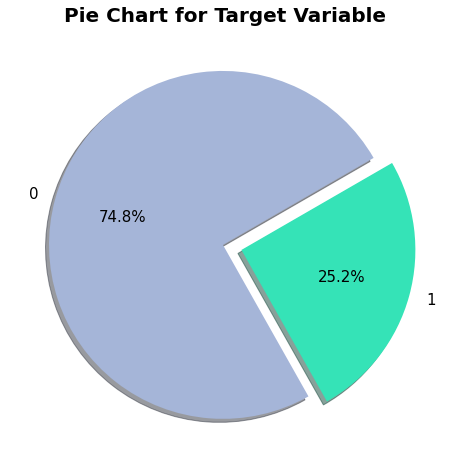

In [15]:
#Brief Exploratory Data Analysis

#Preparing a plot to check the distribution of a target variable named "rating_text" using a Pie Chart

#Defning target values as values in a dataframe we'll use as labels and defninig chart attributes in size, colour, title etc.
labels = ["0", "1"]
sizes = merged_df["target"].value_counts(sort = True)
colors = ["#a5b5d8", "#35e3b7"]
explode = (0.01,0.1) 
plt.figure(figsize=(8,8))

#Plotting the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',     
        shadow=True, startangle=30,textprops={'fontsize': 15})

plt.title("Pie Chart for Target Variable",fontweight = "bold",fontsize = 20)
plt.show() 

In [16]:
#Observing the final dataframe's shape, columns and other characteristics.
merged_df.shape
merged_df['target'].unique()
merged_df.columns


merged_df.drop(axis=1, columns=['customer_ID','S_2'], inplace=True)

#Now we check the dataset for duplicates
if (any(merged_df.duplicated())):  
    print("Yes") 
else:
    print("No")
    
#Checking dataset for missing values and printing the amount of missing values
if(any(merged_df.isna().sum())):
    print("Yes")
else:
    print("No")

#As we've identified dataset has missing values. We now drop these columns with high missing percentage as they're not useful for modelling
#We set thresholds and start dropping columns/variables
i=0
for col in merged_df.columns:   
    if (merged_df[col].isnull().sum()/len(merged_df[col])*100) >=75:      
        print("Dropping column", col)     
        merged_df.drop(labels=col,axis=1,inplace=True)    
        i=i+1
        
print("Total number of columns dropped in train dataframe", i)

#We convert B and D categorical variables to object ypes for being suitable for modelling
merged_df = merged_df.astype({"B_30": 'str', "B_38": 'str'})
merged_df = merged_df.astype({"D_114": 'str', "D_116": 'str', "D_117": 'str', "D_120": 'str', "D_126": 'str', "D_68": 'str'})

No
Yes
Dropping column D_42
Dropping column D_49
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in train dataframe 23


In [17]:
#Separating X and y for further processing
X = merged_df.drop(columns=['target'])
y = merged_df['target']

#Observing shape of these new variables
print("Shape of X", X.shape)
print("Shape of y", y.shape)

Shape of X (307696, 165)
Shape of y (307696,)


In [18]:
#We now print number of rows and columns of datasets indivdually and try to see how the values look like by using head and tail function.
#We pass 3 as parameter in function to view 3 rows. Therefore, we observe the nitial 3 and ending 3 values in the dataset.

print('Number of rows in train dataset:', small_train_df.shape[0])
print('Number of columns in train dataset:', small_train_df.shape[1])

small_train_df.head(3)
small_train_df.tail(3)

Number of rows in train dataset: 307696
Number of columns in train dataset: 190


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
307693,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-10-19,0.765811,0.039258,0.013343,0.264323,0.009409,0.263618,0.005923,0.145822,...,NaN,NaN,NaN,0.006481,0.004048,0.009629,NaN,0.006843,0.005342,0.000434
307694,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-11-07,0.775347,0.009767,0.036882,0.260732,0.004818,0.214820,0.001705,0.146437,...,NaN,NaN,NaN,0.003042,0.001836,0.002594,NaN,0.008017,0.007526,0.007780
307695,0e64cf93cbbd6e29c91f5ededc3b4f617280fa1cfbbb2a...,2017-12-18,0.782801,0.004242,0.041746,0.326571,0.000993,0.200097,0.009124,0.130667,...,NaN,NaN,NaN,0.001586,0.005269,0.000027,NaN,0.001484,0.002760,0.006737


In [19]:
#Now that we know list of categorical and numerical variables, we ready the pipelines for pre-processing purposes.

#Starting with categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('scaler', StandardScaler())])
print(cat_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('scaler', StandardScaler())])


In [20]:
#Preparing numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', StandardScaler())])
print(num_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())])


In [21]:
#Combining these into one through column transformation by identifying the pipelines through column names.
preprocess = ColumnTransformer([
    ('cat', cat_pipe, categ),
    ('num', num_pipe, numer)])
print(preprocess)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['D_63', 'D_64', 'D_68', 'B_30', 'B_38',
                                  'D_114', 'D_116', 'D_117', 'D_120',
                                  'D_126']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 

In [22]:
#We prepare data for modelling by splitting into train and test sets for beoth x and y. 
#x without target values and y being with target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

#Visualising shape of newly created datasets
print("X_train Shape:", X_train.shape)
print("X_test Shape", X_test.shape)
print("y_train Shape", y_train.shape)      
print("y_test Shape", y_test.shape)

X_train Shape: (230772, 165)
X_test Shape (76924, 165)
y_train Shape (230772,)
y_test Shape (76924,)


In [23]:
#Now we have pre-processing functionalities defined we define Amex evaluation metrics.
#The code has already been provided by Amex and has just been fit with model values

#The functions calucate evaluation metric M. It is the mean of two measures of rank ordering: Normalized Gini Coefficient, G , and default rate captured at 4%, D.
#The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.
#For both of the sub-metrics  and , the negative labels are given a weight of 20 to adjust for downsampling.
#This metric has a maximum value of 1.0.

#Start of Amex evaluation metric code
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()
    
    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)
    return 0.5 * (g + d)

#End of Amex evaluation metric code.

In [40]:
#Preparatin of model functions for model building, training and evaluation. Preparing functions help conserve code and perform models in pipeline functions
#This approach saves us space in code size and keeps things streamlines for error identification and debugging.
#It also helps reusabilitiy and quality assurance with same conditions applied for every classifier without a hint of developer error in a specific code function for a classifier.

#Defining estimator that will select features for modelling.
estimator = RandomForestClassifier(n_estimators = 10, random_state = 42, n_jobs = -1)

#The function incorporates various stages of this modeling process
#RandomForestClassifier is fitted by default which will be changes individually for each classifier that is run using set_params.
part = [('preprocess', preprocess),
        ('over_sampler',SMOTE(random_state = 42)),
        ('under_sampler',RandomUnderSampler()),
        ('feature_selection', SelectFromModel(estimator)), 
        ('dimension_reduction', PCA(n_components='mle',random_state = 42)),
        ('estimating_model', RandomForestClassifier(random_state = 42))]

#defnining object pipe for the set up pipeline
pipe = Pipeline(part, verbose=True)

#We define a function that evaluates our classifier on different metrics such as accuracy, recall, AUC, confusion matrix, f1 score, AUC score, etc.
def evaluation_score(model_name):
    print("------------------------------------------------------")
    print("Model Name:\n", model_name)
    print("------------------------------------------------------") 
    print("->Performing imputation on missing categorical variables along with encoding and scaling.\n")  
    print("->Perfomring imputation and scaling for numeric variable:\n") 
    model = pipe.fit(X_train, y_train)  
    print("------------------------------------------------------")
    pred = pipe.predict(X_test)
    print("------------------------------------------------------")
    cm= confusion_matrix(y_test, pred) 
    print('Confusion matrix\n\n', cm)   
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    print("------------------------------------------------------")
    #Now we have defined columns values for true positives, true negatives, false positives and false negatives, 
    #we visualise them through heatmap from seaborn library using object sns.
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    
    print("------------------------------------------------------")
    print("\nModel Accuracy Score:", accuracy_score(y_test, pred))
    print("\nModel Precision Score: ", precision_score(y_test, pred))
    print("\nModel Recall Score: ", recall_score(y_test, pred))
    print("\nModel F1 score:", f1_score(y_test, pred))
    print("\nModel AUC Score:", roc_auc_score(y_test, pred))
    print("------------------------------------------------------")
    print("--------------Classification Report-------------------")
    print(classification_report(y_test, pred))
    print("------------------------------------------------------")
    print("Amex Evaluation Metric - Training: %.3f"% amex_metric(pd.DataFrame(y_train), pd.DataFrame(pipe.predict(X_train), columns=['prediction'])))
    print("Amex Evaluation Metric - Validation: %.3f"% amex_metric(pd.DataFrame(y_test), pd.DataFrame(pipe.predict(X_test), columns=['prediction'])))
    print("------------------------------------------------------")

------------------------------------------------------
Model Name:
 RandomForestClassifier
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   8.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  30.1s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  38.3s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   1.1s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total= 7.7min
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[51634  5939]
 [ 1549 17802]]

True Positives(TP) =  51634

True Negatives(TN) =  17802

False Positives(FP) =  5939

False Negatives(FN) =  1549
-

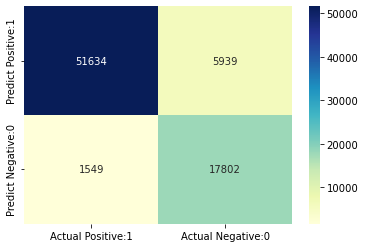

In [41]:
#Begining of Model Results
#We start by running Ramdom Forest Classifier
evaluation_score("RandomForestClassifier")

------------------------------------------------------
Model Name:
 XGBClassifier
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=  10.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  40.9s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.7s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  53.5s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   1.0s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total= 4.4min
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[49136  8437]
 [ 2005 17346]]

True Positives(TP) =  49136

True Negatives(TN) =  17346

False Positives(FP) =  8437

False Negatives(FN) =  2005
----------

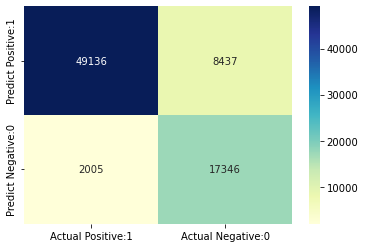

In [42]:
#Changing function paramters to XGBClassifier for next model execution
pipe.set_params(estimating_model = XGBClassifier())
#Running XGB(Extreme Gradient Boosting) Classifier.
evaluation_score("XGBClassifier")

------------------------------------------------------
Model Name:
 DecisionTreeClassifier
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   7.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  36.6s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  49.6s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   1.1s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total=  35.8s
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[50558  7015]
 [ 4083 15268]]

True Positives(TP) =  50558

True Negatives(TN) =  15268

False Positives(FP) =  7015

False Negatives(FN) =  4083
-

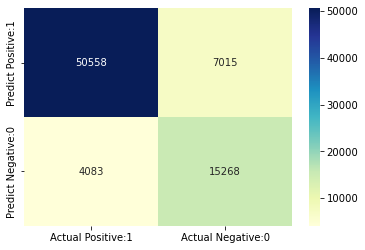

In [43]:
#Changing function paramters to DecisionTreeClassifier for next model execution
pipe.set_params(estimating_model=DecisionTreeClassifier())
#Running Decision Tree Classifier.
evaluation_score("DecisionTreeClassifier")

------------------------------------------------------
Model Name:
 LogisticRegression
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   7.5s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  43.5s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.7s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  51.1s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   1.2s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total=   3.6s
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[47843  9730]
 [ 2501 16850]]

True Positives(TP) =  47843

True Negatives(TN) =  16850

False Positives(FP) =  9730

False Negatives(FN) =  2501
-----

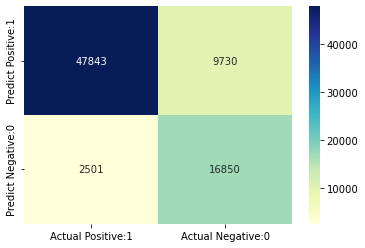

In [44]:
#Changing function paramters to LogisticRegression for next model execution
pipe.set_params(estimating_model=LogisticRegression())
#Running Logistic Regression.
evaluation_score("LogisticRegression")

------------------------------------------------------
Model Name:
 LinearSVC
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=  11.5s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  36.8s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  45.9s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   1.0s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total= 2.6min
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[47514 10059]
 [ 2404 16947]]

True Positives(TP) =  47514

True Negatives(TN) =  16947

False Positives(FP) =  10059

False Negatives(FN) =  2404
-------------

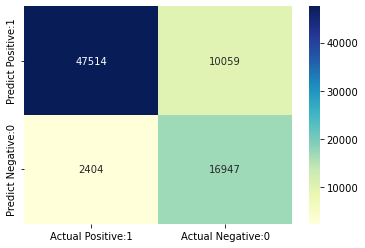

In [45]:
#Changing function paramters to LinearSVC for next model execution
pipe.set_params(estimating_model=LinearSVC())
#Running Linear Support Vector Classifier.
evaluation_score("LinearSVC")

------------------------------------------------------
Model Name:
 GaussianNB
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   7.3s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  35.0s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.5s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  41.4s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.8s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total=   0.3s
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[45507 12066]
 [ 3368 15983]]

True Positives(TP) =  45507

True Negatives(TN) =  15983

False Positives(FP) =  12066

False Negatives(FN) =  3368
------------

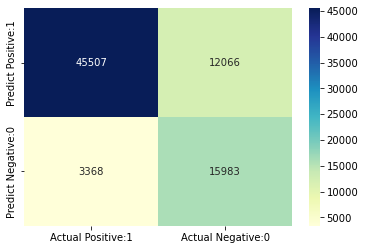

In [46]:
#Changing function paramters to GaussianNB for next model execution
pipe.set_params(estimating_model=GaussianNB())
#Running Gaussian Naive Bayes Classifier.
evaluation_score("GaussianNB")

------------------------------------------------------
Model Name:
 KNeighborsClassifier
------------------------------------------------------
->Performing imputation on missing categorical variables along with encoding and scaling.

->Perfomring imputation and scaling for numeric variable:

[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   7.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  29.6s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  36.8s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.8s
[Pipeline] .. (step 6 of 6) Processing estimating_model, total=   0.1s
------------------------------------------------------
------------------------------------------------------
Confusion matrix

 [[52677  4896]
 [ 1092 18259]]

True Positives(TP) =  52677

True Negatives(TN) =  18259

False Positives(FP) =  4896

False Negatives(FN) =  1092
---

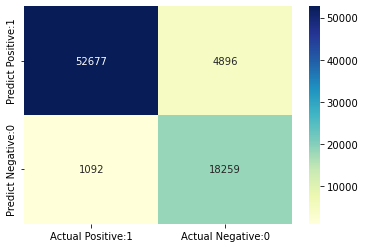

In [47]:
#Changing function paramters to KNeighborsClassifier for next model execution
pipe.set_params(estimating_model=KNeighborsClassifier())
#Running KNeighbors Classifier.
evaluation_score("KNeighborsClassifier")

## Conclusion
After running and evaluating all models we notice that K Neighbors Classifier has the highest AUC score followed by Random Forest and then Extreme Gradient Boosting Classifier. Therefore, K Neghbors Classifier is the ideal classifier we'll use for predictions in submission file.